In [1]:
# 手寫數字辨識 (Tensorflow 利用 MLP 與 CNN 模型)
import numpy as np
import pandas as pd
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import tensorflow.examples.tutorials.mnist.input_data as input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
import otherLib as olib
olib.solve_cudnn_error() # 處理 GPN memory 分配

Instructions for updating:
non-resource variables are not supported in the long term
Instructions for updating:
Please use alternatives such as: tensorflow_datasets.load('mnist')
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/_DataSet.py from tensorflow/models.
1 Physical GPUs, 1 Logical GPUs


In [2]:
#查看測試集數量
print('train', mnist.train.num_examples)
print('validation', mnist.validation.num_examples)
print('test', mnist.test.num_examples)

train 55000
validation 5000
test 10000


In [3]:
#查看單一圖大小及標籤大小
#圖  (28*28=784)
#標籤(0-9)
print('train_image', mnist.train.images.shape)
print('labels', mnist.train.labels.shape)

train_image (55000, 784)
labels (55000, 10)


In [4]:
#查看第一張圖 (已正規化)
mnist.train.images[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

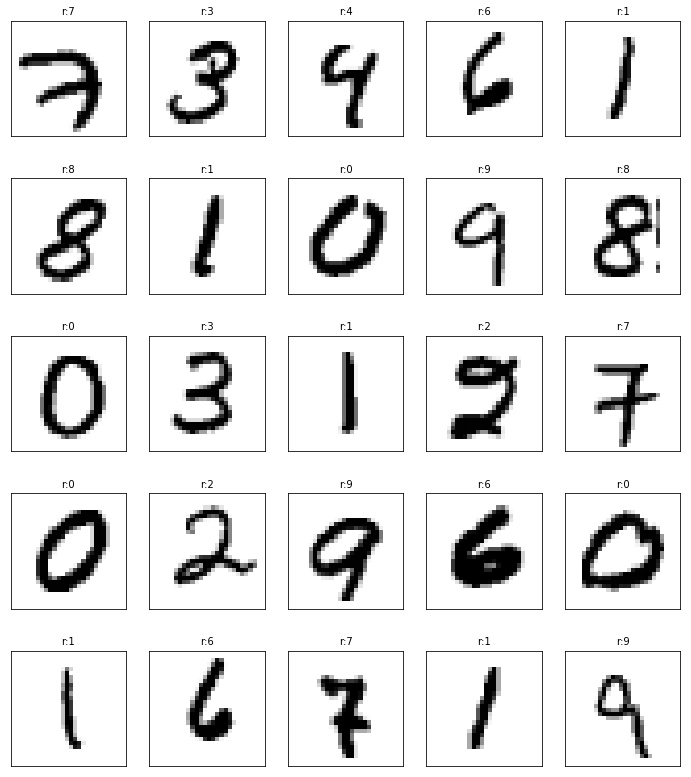

In [5]:
# 查看影像
olib.plot_prediction(
    mnist.train.images.reshape(-1,28,28), 
    np.argmax(mnist.train.labels, axis=-1), 
    [], 0)

In [6]:
# MLP 模型
# 1層輸入層 784 神經元
# 1層隱藏層輸入 784 輸出 3136
# 1層隱藏層輸入 3136 輸出 784
# 1層輸出層輸入 784 輸出 10
x = tf.placeholder("float", [None, 784])
h1 = olib.tf_layer(3136, 784, x, tf.nn.relu)
h2 = olib.tf_layer(784, 3136, h1, tf.nn.relu)
y_predict = olib.tf_layer(10,  784, h2)

In [7]:
# 真實資料也需設定 placeholder
y_label = tf.placeholder("float", [None, 10])

In [8]:
# 使用 tensorflow 自行設定最佳化方法(相比於 keras 的 compile)
# 損失函數
# 優選方法
# 評估方法
loss_f = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits=y_predict, labels=y_label)
) #交叉熵

optimizer = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(loss_f) # adam

correct_prediction = tf.equal(tf.argmax(y_predict,1), tf.argmax(y_label,1)) #預測值與真實質相等
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float")) #correct_prediction 轉 float 後平均

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [9]:
# 使用 tensorflow 自行設定訓練方式(相比於 keras 的 fit)
# 訓練: 10 次
# 每批次: 500 筆資料
epochs = 10
batch_size = 500
total_batchs = int(mnist.train.num_examples / batch_size)
loss_list = []; epoch_list = []; accuracy_list = []

sess = tf.Session()
sess.run(tf.global_variables_initializer())
for epoch in range(epochs):
    # 開始該輪逐筆批次訓練
    for i in range(total_batchs):
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        sess.run(optimizer, feed_dict={
                x:      batch_x,
                y_label:batch_y
        })
    
    # 訓練完成，計算該次準確率與誤差
    loss, acc = sess.run([loss_f, accuracy],feed_dict={
            x:      mnist.validation.images,
            y_label:mnist.validation.labels
    })

    # 記錄至 list
    epoch_list.append(epoch)
    loss_list.append(loss)
    accuracy_list.append(acc)

    #print("Train epoch: ","%02d" %(epoch+1), "Loss=","{:.9f}".format(loss), "Accurcy=", acc)
    print("Train epoch: %02d, Loss=%0.4f, Accurcy=%0.4f" % (epoch+1, loss, acc))

Train epoch: 01, Loss=1612.8715, Accurcy=0.5476
Train epoch: 02, Loss=839.4358, Accurcy=0.7268
Train epoch: 03, Loss=608.2236, Accurcy=0.7934
Train epoch: 04, Loss=493.9892, Accurcy=0.8282
Train epoch: 05, Loss=423.4465, Accurcy=0.8504
Train epoch: 06, Loss=378.1587, Accurcy=0.8674
Train epoch: 07, Loss=342.4238, Accurcy=0.8750
Train epoch: 08, Loss=315.1476, Accurcy=0.8858
Train epoch: 09, Loss=294.2311, Accurcy=0.8894
Train epoch: 10, Loss=273.5271, Accurcy=0.8944


In [10]:
# 訓練完成，驗證準確度
print("Accuracy:", sess.run(accuracy, feed_dict={
        x:      mnist.test.images,
        y_label:mnist.test.labels
}))

Accuracy: 0.8958


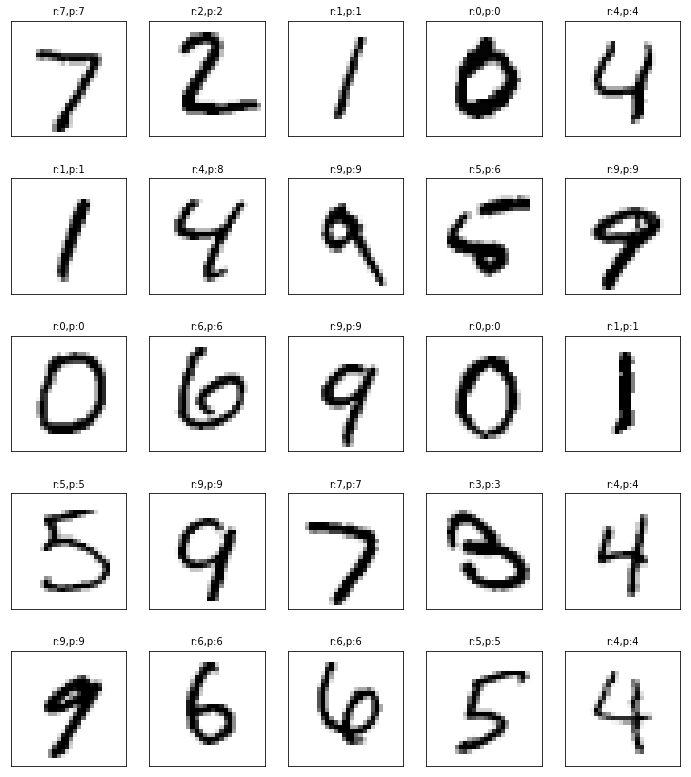

In [11]:
# 訓練完成，預測
prediction_MLP = sess.run(tf.argmax(y_predict, 1),feed_dict={
    x: mnist.test.images
})

olib.plot_prediction(
    mnist.test.images.reshape(-1,28,28), 
    np.argmax(mnist.test.labels, axis=-1), 
    prediction_MLP, 0)

In [12]:
# 自行設定權重與偏差方法
def weight(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.1), name= "W")

def bias(shape):
    return tf.Variable(tf.constant(0.1, shape=shape, name="b"))

In [13]:
# 自行設定捲積方法
def conv2d(x, W):
    return tf.nn.conv2d( x, W, strides=[1,1,1,1], padding="SAME")

In [14]:
# 自行設定池化方法
def pool_2x2(x):
    return tf.nn.max_pool( x, ksize=[1,2,2,1], strides=[1,2,2,1], padding="SAME")

In [15]:
# CNN 模型
# 1層輸入層 28*28 神經元 輸入 1 輸出 1
# 1層捲積層 28*28 神經元 輸入 1 輸出 16
# 1層池化層 14*14 神經元 輸入 16 輸出 16
# 1層捲積層 14*14 神經元 輸入 16 輸出 36
# 1層池化層 7*7 神經元   輸入 36 輸出 36
# 1層平坦層輸入 36*7*7 輸出 1764
# 1層隱藏層輸入 1764 輸出 3136 dropout 0.2
# 1層隱藏層輸入 3136 輸出 784 dropout 0.2
# 1層輸出層輸入 784 輸出 10
with tf.name_scope("Input"):
    x = tf.placeholder("float", shape=[None, 784], name="x")
    x_image = tf.reshape(x, [-1, 28, 28, 1]) # 長*寬*彩度

with tf.name_scope("Conv1"):
    W1 = weight([5,5,1,16])
    b1 = bias([16])
    conv1 = tf.nn.relu(conv2d(x_image, W1) + b1)

with tf.name_scope("Pool1"):
    pool1 = pool_2x2(conv1)

with tf.name_scope("Conv2"):
    W2 = weight([5,5,16,36])
    b2 = bias([36])
    conv2 = tf.nn.relu(conv2d(pool1, W2) + b2)

with tf.name_scope("Pool2"):
    pool2 = pool_2x2(conv2)

with tf.name_scope("Flat"):
    flat = tf.reshape(pool2, [-1, 1764])

with tf.name_scope("Hidden1"):
    W3 = weight([1764,3136])
    b3 = bias([3136])
    h1 = tf.nn.relu(tf.matmul(flat, W3) + b3)
    h1_droped = tf.nn.dropout(h1, rate=0.2)

with tf.name_scope("Hidden2"):
    W4 = weight([3136,784])
    b4 = bias([784])
    h2 = tf.nn.relu(tf.matmul(h1_droped, W4) + b4)
    h2_droped = tf.nn.dropout(h2, rate=0.2)

with tf.name_scope("Output2"):
    W5 = weight([784,10])
    b5 = bias([10])
    y_predict = tf.nn.relu(tf.matmul(h2_droped, W5) + b5)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [16]:
# 使用 tensorflow 自行設定最佳化方法
# 損失函數
# 優選方法
# 評估方法
with tf.name_scope("Optimizer"):
    loss_f = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits=y_predict, labels=y_label)
    ) #交叉熵

    optimizer = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(loss_f) # adam

    correct_prediction = tf.equal(tf.argmax(y_predict,1), tf.argmax(y_label,1)) #預測值與真實質相等
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float")) #correct_prediction 轉 float 後平均

In [17]:
# 使用 tensorflow 自行設定訓練方式
# 訓練: 10 次
# 每批次: 500 筆資料
epochs = 10
batch_size = 500
total_batchs = int(mnist.train.num_examples / batch_size)
loss_list = []; epoch_list = []; accuracy_list = []

sess = tf.Session()
sess.run(tf.global_variables_initializer())
for epoch in range(epochs):
    # 開始該輪逐筆批次訓練
    for i in range(total_batchs):
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        sess.run(optimizer, feed_dict={
                x:      batch_x,
                y_label:batch_y
        })
    
    # 訓練完成，計算該次準確率與誤差
    loss, acc = sess.run([loss_f, accuracy],feed_dict={
            x:      mnist.validation.images,
            y_label:mnist.validation.labels
    })

    # 記錄至 list
    epoch_list.append(epoch)
    loss_list.append(loss)
    accuracy_list.append(acc)

    #print("Train epoch: ","%02d" %(epoch+1), "Loss=","{:.9f}".format(loss), "Accurcy=", acc)
    print("Train epoch: %02d, Loss=%0.4f, Accurcy=%0.4f" % (epoch+1, loss, acc))

Train epoch: 01, Loss=2.1197, Accurcy=0.1940
Train epoch: 02, Loss=2.0733, Accurcy=0.2026
Train epoch: 03, Loss=2.0634, Accurcy=0.2042
Train epoch: 04, Loss=1.8488, Accurcy=0.2478
Train epoch: 05, Loss=1.3242, Accurcy=0.5270
Train epoch: 06, Loss=0.2798, Accurcy=0.9226
Train epoch: 07, Loss=0.1531, Accurcy=0.9554
Train epoch: 08, Loss=0.1226, Accurcy=0.9654
Train epoch: 09, Loss=0.1059, Accurcy=0.9690
Train epoch: 10, Loss=0.0863, Accurcy=0.9748
